## Description :
- The Idea is to have an LLM that break down a User request to steps in a specific order.
- A new method call **create_react_agent** : Creates a graph that works with a chat model that utilizes tool calling..

## Setup :

curl -fsSL https://ollama.com/install.sh | sh

ollama pull llama3-groq-tool-use:8b

ollama pull llama3.1:8b-instruct-fp16

ollama pull mistral-nemo:12b-instruct-2407-fp16       

ollama pull codegeex4:latest  `Not working with Function calling , but is good at Code related tasks`

ollama pull nomic-embed-text  `For Embedding`



\n

## Build LLMs and Agents :

### LLMs :

#### Planer

In [1]:
import os
os.environ["FIREWORKS_API_KEY"] = "lapNGjpfc3RIJrcneGK28tRqAUSbch1AFcGI8fAdvAaGVfud" 

In [21]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing import List,Any
#import ast
from langchain_fireworks import ChatFireworks

class Plan(BaseModel):
    """Plan to follow in future"""
    Next_Step:  str = Field(...,description = "This is the Next Step to be executed")
    Next_Node : Literal["Tavily","PythoInterp","Coder","Resumer"] = Field(...,description = "This is the Next Node Name")
    Node_Input: str = Field(...,description = "This is the Next Node Input")


# LLM with Structered Output
#llm = ChatOpenAI(api_key="ollama",model="mistral-nemo:12b-instruct-2407-fp16",base_url="http://localhost:11434/v1")
llm = ChatFireworks(model="accounts/fireworks/models/llama-v3p1-70b-instruct")
structured_llm_planer = llm.with_structured_output(Plan)

# Prompt
system = """ You are an expert manager and Planer. for a given
- User request                   : {User_Request}\n
- The Last executed Step         : {Last_Step} \n
- The Last executed Step result  : {Step_Result}\n
You Should give the give next step,the Next Node to perform the step, and the Node Input.\n
Nodes are Tools or LLMs like you, they can perform a step.\n
Tools are :\n
- Tavily            : A web search engine Like google, useful when you need data from the net, events, statistiques... \n
- Tavily Input      : an optimized search query.\n
- PythoInterp       : A python interpeter to run python Code.\n
- PythoInterp Input : is a Python Code in a string format.\n
LLMs are : \n
- Coder       : an expert developer and code writer.useful to write Python Code.\n
- Coder Input : is a request to generate a python Code, don't forget to add any important data that the coder may need.\n
- Resumer : an expert at resuming and extracting main informations from the Tavily results.\n   
- Coder Input : is a request to resume or extract main informations for Tavily results, don't forget to add Tavily results in this input.\n 
You Sructure your response in a python Dictionary with keys are :
    Next_Step:  str = Field(...,description = "This is the Next Step to be executed")
    Next_Node : Literal["Tavily","PythoInterp","Coder","Resumer"] = Field(...,description = "This is the Next Node Name")
    Node_Input: str = Field(...,description = "This is the Next Node Input")
"""

planer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system)
    ]
)


  
Planer = planer_prompt | llm 

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os

os.environ["TAVILY_API_KEY"] = "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"
Tavily = TavilySearchResults(max_results=3)
response =Tavily.invoke("the winner of Australia open 2024")

In [22]:
input = {"User_Request":"what is the hometown of the current Australia open winner 2024?",
"Last_Step":"Get the Name of the winner of Australia open 2024",
"Step_Result":response}
response = Planer.invoke(input)
response

AIMessage(content='Here is the response:\n\n```\n{\n    "Next_Step": "Get the Name of the winner of Australia open 2024",\n    "Next_Node": "Tavily",\n    "Node_Input": "Australia Open 2024 winner"\n}\n```\n\nExplanation:\n\nSince the last executed step was "Get the Name of the winner of Australia open 2024" and it returned None, we need to try again to get the name of the winner. The best way to do this is by using the Tavily search engine to search for the winner of the Australia Open 2024. The search query is "Australia Open 2024 winner".', response_metadata={'token_usage': {'prompt_tokens': 383, 'total_tokens': 518, 'completion_tokens': 135}, 'model_name': 'accounts/fireworks/models/llama-v3p1-70b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop', 'logprobs': None}, id='run-c74d64ff-dea0-4eb4-b02f-8e555e2a46ee-0', usage_metadata={'input_tokens': 383, 'output_tokens': 135, 'total_tokens': 518})

In [23]:
print(response.content)

Here is the response:

```
{
    "Next_Step": "Get the Name of the winner of Australia open 2024",
    "Next_Node": "Tavily",
    "Node_Input": "Australia Open 2024 winner"
}
```

Explanation:

Since the last executed step was "Get the Name of the winner of Australia open 2024" and it returned None, we need to try again to get the name of the winner. The best way to do this is by using the Tavily search engine to search for the winner of the Australia Open 2024. The search query is "Australia Open 2024 winner".


#### Worker_Graph :

In [4]:
from Graphs import Worker_Graph

## Initialize The Graph:

In [5]:
from typing_extensions import TypedDict
import pandas as pd
from langgraph.graph import StateGraph, START, END
from typing import Annotated,List
from langgraph.graph.message import add_messages

class Super_State(TypedDict):
    question :str
    messages: Annotated[list, add_messages]
    Plan  : List[str]
    Done : bool

graph_builder = StateGraph(Super_State)

## Nodes Functions :

### LLMs:

In [6]:
def Planer_function(state:Super_State):
    User_resquest = state["question"]
    input = {"question":User_resquest}
    response = Planer.invoke(input)
    return {"Plan":response}

def Print_Messgaes(Messages):
    for message in Messages["messages"]:
        print(message)

def Run_Worker(state:Super_State,Task):
    Input_Message = {"messages": [("human", Task)]}
    config = {"configurable": {"thread_id": "1"}}
    Worker_messages = Worker_Graph.invoke(Input_Message,config)
    #print(Worker_messages)
    Print_Messgaes(Worker_messages)
    return {"messages":Worker_messages}

def Worker_function(state:Super_State):
    Plan = state["Plan"]
    for i,task in enumerate(Plan):
        Run_Worker(state,task)
        print(f"Task {i} has been executed")
       
    return {"Done":True}

def Condition(state:Super_State):
    if state["Done"]:
        return "Finish"

## Design the Graph:

### Build :

In [7]:
graph_builder.add_node("Planer",Planer_function)
graph_builder.add_node("Worker_Graph",Worker_function)

In [8]:
graph_builder.add_edge(START,"Planer")
graph_builder.add_edge("Planer","Worker_Graph")
graph_builder.add_conditional_edges("Worker_Graph",Condition,{"Finish":"__end__"})

In [9]:
Super_Graph = graph_builder.compile()

### Visualize :

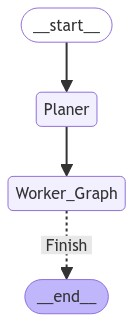

In [10]:
from IPython.display import Image, display

try:
    display(Image(Super_Graph.get_graph(xray= True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Interact with The Graph :

In [11]:
# Run
input = {"question":"what is the hometown of the current Australia open winner?"}

for output in Super_Graph.stream(input):
    for key, value in output.items():
        # Node
        print(f"Node :{key}")
        print(f"State :{value}")
    print("\n")

Node :Planer
State :{'Plan': ['Search for recent Australia Open tennis tournament information', "Identify the current tournament champion's name", 'Look up brief biographical information on this player', 'Select information about their hometown or birthplace', 'Review information to confirm final answer']}


content='Search for recent Australia Open tennis tournament information' id='dd00bfa7-8be4-42ea-b226-3fcd02f1e350'
content='' additional_kwargs={'tool_calls': [{'id': 'call_6ghs7fwb', 'function': {'arguments': '{"query":"Australia Open tennis recently results"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 185, 'total_tokens': 210}, 'model_name': 'llama3.1:8b-instruct-fp16', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-9740869d-f964-4e90-bc83-0f88c13007f1-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Australia Open t